In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

Mounted at /content/drive


# BTC

In [2]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv')
df1=df.reset_index()['Close']
df1

0       13657.200195
1       14982.099609
2       15201.000000
3       15599.200195
4       17429.500000
            ...     
1984    26508.216797
1985    26480.375000
1986    25851.240234
1987    25940.167969
1988    25902.500000
Name: Close, Length: 1989, dtype: float64

In [3]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:2:1

In [4]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)
print(X_val.shape)
print(yval.shape)

(1291, 100)
(1291,)
(296, 100)
(296,)
(99, 100)
(99,)


In [8]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 13s 252ms/step - loss: 0.0207 - val_loss: 0.0122
Epoch 2/100
21/21 [==============================] - 4s 188ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 3/100
21/21 [==============================] - 6s 281ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4/100
21/21 [==============================] - 4s 183ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 5/100
21/21 [==============================] - 4s 194ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 6/100
21/21 [==============================] - 6s 276ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 7/100
21/21 [==============================] - 4s 187ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/100
21/21 [==============================] - 4s 192ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 9/100
21/21 [==============================] - 6s 291ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 10/100
21/21 [==============================] - 4s 191ms/step - loss: 0.0015 - val_l

In [12]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 52ms/step


In [13]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [14]:
test_data.shape

(397, 1)

In [15]:
y_pred.shape

(296, 1)

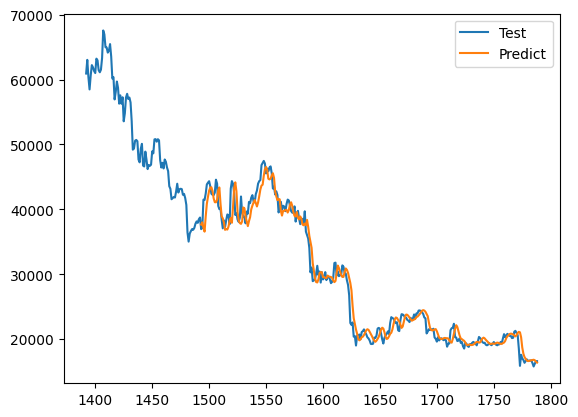

In [16]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

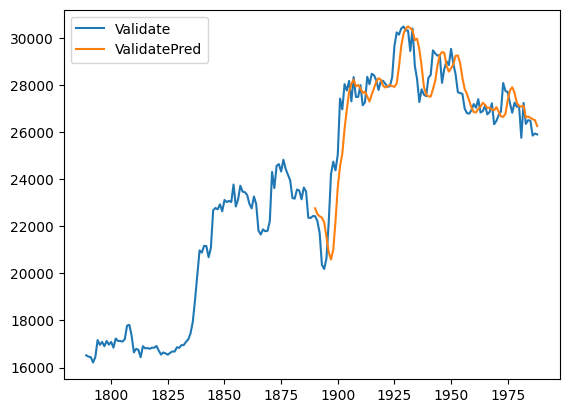

In [17]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

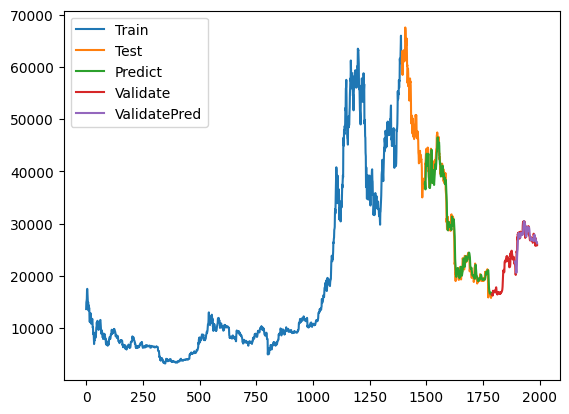

In [18]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [19]:


print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 7357641.386524111
MAE: 27209.390586301426
RMSE: 27294.09753269535
--------------------------
---------TEST----------
MAPE: 8320689.194778599
MAE: 28234.918374631394
RMSE: 29699.10120066168
-------------------


## 5:3:2

In [20]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [21]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [22]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [23]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 389ms/step - loss: 0.0014 - val_loss: 0.1349
Epoch 2/100
14/14 [==============================] - 4s 267ms/step - loss: 3.4274e-04 - val_loss: 0.0130
Epoch 3/100
14/14 [==============================] - 3s 218ms/step - loss: 1.9028e-04 - val_loss: 0.0181
Epoch 4/100
14/14 [==============================] - 3s 235ms/step - loss: 1.6338e-04 - val_loss: 0.0169
Epoch 5/100
14/14 [==============================] - 4s 328ms/step - loss: 1.5181e-04 - val_loss: 0.0126
Epoch 6/100
14/14 [==============================] - 4s 262ms/step - loss: 1.4040e-04 - val_loss: 0.0119
Epoch 7/100
14/14 [==============================] - 3s 215ms/step - loss: 1.4162e-04 - val_loss: 0.0107
Epoch 8/100
14/14 [==============================] - 3s 232ms/step - loss: 1.2537e-04 - val_loss: 0.0108
Epoch 9/100
14/14 [==============================] - 5s 355ms/step - loss: 1.2138e-04 - val_loss: 0.0099
Epoch 10/100
14/14 [==============================] - 3s 2

In [26]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 39ms/step


In [27]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

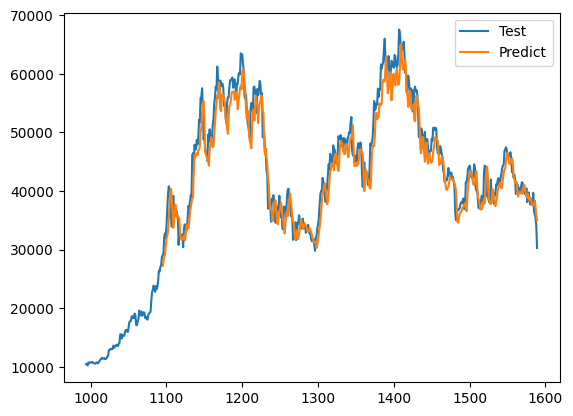

In [28]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1 + test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start = train_size1 + 101, stop = train_size1 + test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

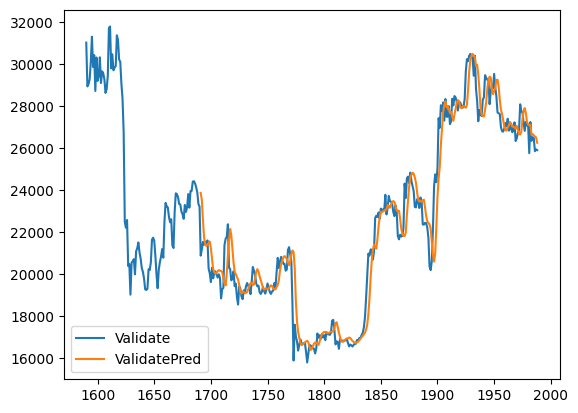

In [29]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [30]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 7943616.025885014
MAE: 22286.843369921335
RMSE: 22675.205600395286
--------------------------
---------TEST----------
MAPE: 7038515.45610988
MAE: 44432.9835723367
RMSE: 45202.58101774454
-------------------


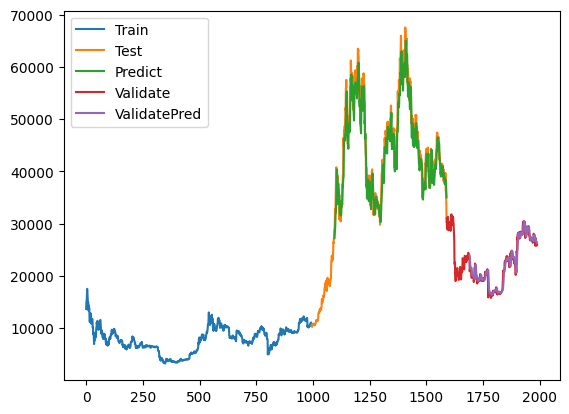

In [31]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# DOGE

In [32]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.008909
1       0.009145
2       0.009320
3       0.009644
4       0.012167
          ...   
1984    0.067966
1985    0.069489
1986    0.061860
1987    0.061587
1988    0.061459
Name: Close, Length: 1989, dtype: float64

In [33]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:2:1

In [34]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [35]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [38]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 14s 372ms/step - loss: 0.0072 - val_loss: 0.0010
Epoch 2/100
21/21 [==============================] - 4s 188ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/100
21/21 [==============================] - 4s 197ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/100
21/21 [==============================] - 6s 276ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 5/100
21/21 [==============================] - 4s 186ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 6/100
21/21 [==============================] - 4s 209ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
21/21 [==============================] - 10s 486ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/100
21/21 [==============================] - 10s 476ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
21/21 [==============================] - 9s 422ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 10/100
21/21 [==============================] - 6s 279ms/step - loss: 0.0014 - val

In [41]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 33ms/step


In [42]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [43]:
test_data.shape

(397, 1)

In [44]:
y_pred.shape

(296, 1)

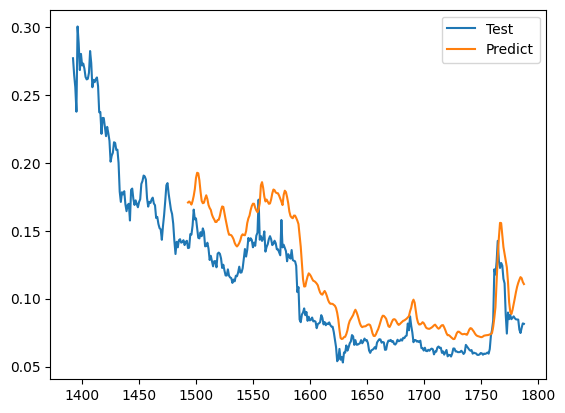

In [45]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

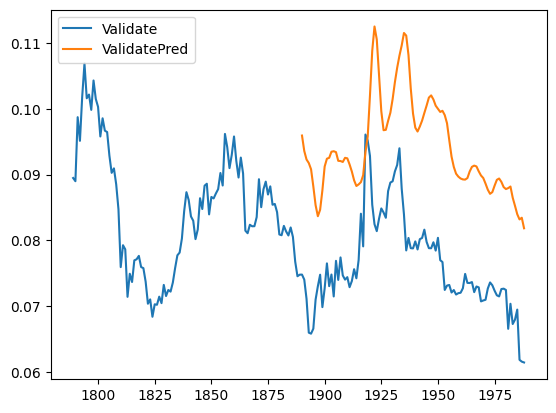

In [46]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [47]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 14.48045625390928
MAE: 0.016487854901069673
RMSE: 0.019742665602940912
--------------------------
---------TEST----------
MAPE: 37.90230517667916
MAE: 0.05186332081572481
RMSE: 0.06533479896845765
-------------------


In [48]:
val_data.shape

(200, 1)

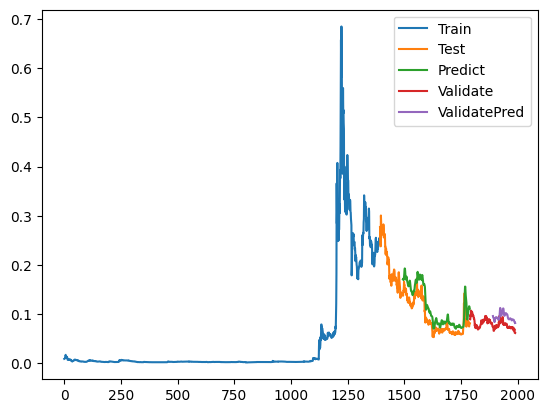

In [49]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [50]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [51]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [52]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [53]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [54]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [55]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 12s 430ms/step - loss: 5.0308e-05 - val_loss: 0.0946
Epoch 2/100
14/14 [==============================] - 3s 232ms/step - loss: 8.4627e-06 - val_loss: 0.0960
Epoch 3/100
14/14 [==============================] - 3s 226ms/step - loss: 3.2104e-06 - val_loss: 0.0964
Epoch 4/100
14/14 [==============================] - 4s 298ms/step - loss: 2.4160e-06 - val_loss: 0.0958
Epoch 5/100
14/14 [==============================] - 4s 254ms/step - loss: 2.0119e-06 - val_loss: 0.0947
Epoch 6/100
14/14 [==============================] - 3s 222ms/step - loss: 1.9376e-06 - val_loss: 0.0933
Epoch 7/100
14/14 [==============================] - 3s 208ms/step - loss: 1.8868e-06 - val_loss: 0.0917
Epoch 8/100
14/14 [==============================] - 4s 257ms/step - loss: 1.8528e-06 - val_loss: 0.0899
Epoch 9/100
14/14 [==============================] - 4s 315ms/step - loss: 1.8172e-06 - val_loss: 0.0878
Epoch 10/100
14/14 [==============================] - 

In [56]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 1s 62ms/step


In [57]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

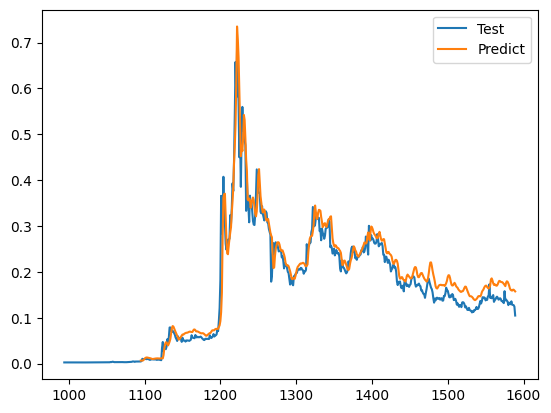

In [58]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

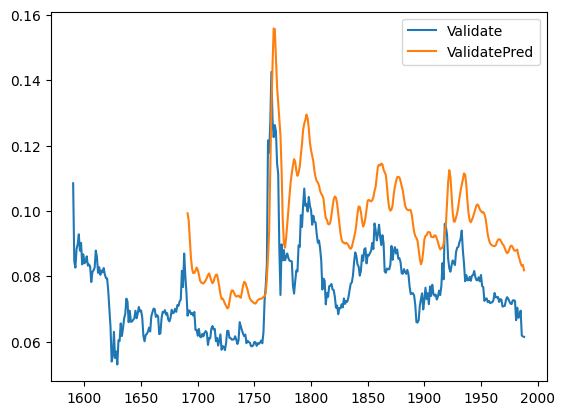

In [59]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [60]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 19.69781610299118
MAE: 0.023416063737410005
RMSE: 0.030309815144743905
--------------------------
---------TEST----------
MAPE: 179.47918911466076
MAE: 0.16308879671379942
RMSE: 0.21238936682153026
-------------------


In [61]:
val_data1.shape

(399, 1)

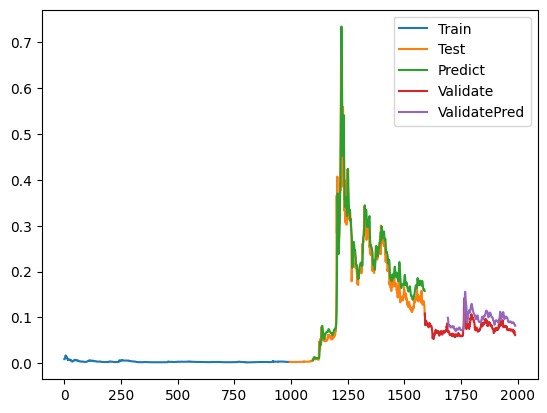

In [62]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# ETH

In [63]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.008909
1       0.009145
2       0.009320
3       0.009644
4       0.012167
          ...   
1984    0.067966
1985    0.069489
1986    0.061860
1987    0.061587
1988    0.061459
Name: Close, Length: 1989, dtype: float64

In [64]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:2:1

In [65]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [66]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [67]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [68]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [69]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [70]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 14s 332ms/step - loss: 0.0081 - val_loss: 0.0035
Epoch 2/100
21/21 [==============================] - 4s 188ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 3/100
21/21 [==============================] - 4s 186ms/step - loss: 0.0023 - val_loss: 6.8751e-04
Epoch 4/100
21/21 [==============================] - 5s 258ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/100
21/21 [==============================] - 4s 202ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 6/100
21/21 [==============================] - 4s 196ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/100
21/21 [==============================] - 5s 252ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/100
21/21 [==============================] - 5s 214ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/100
21/21 [==============================] - 4s 189ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
21/21 [==============================] - 5s 234ms/step - loss: 0.0014 - v

In [72]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 33ms/step


In [73]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [74]:
test_data.shape

(397, 1)

In [75]:
y_pred.shape

(296, 1)

In [76]:
val_data.shape

(200, 1)

In [77]:
y_pred_val.shape

(99, 1)

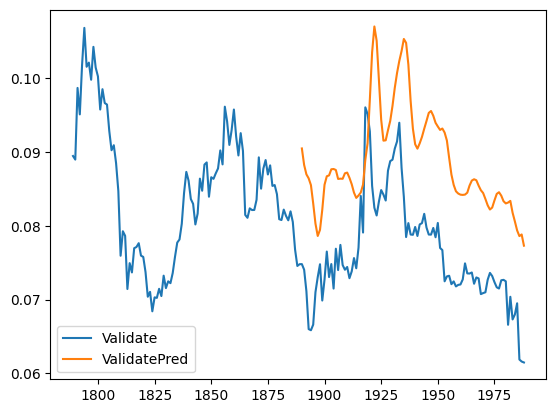

In [78]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,(y_pred_val))

plt.legend(['Validate','ValidatePred'])
plt.show()

In [79]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 18.62047028896106
MAE: 0.02106846216740712
RMSE: 0.024048232827575518
--------------------------
---------TEST----------
MAPE: 37.517394298358546
MAE: 0.052753402346367065
RMSE: 0.06609331456501617
-------------------


In [80]:
val_data.shape

(200, 1)

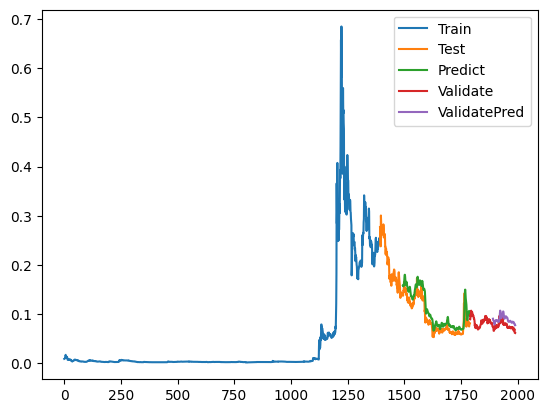

In [81]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [82]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [83]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [84]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [85]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [86]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_16 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [87]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 317ms/step - loss: 7.6451e-05 - val_loss: 0.0946
Epoch 2/100
14/14 [==============================] - 3s 226ms/step - loss: 9.8804e-06 - val_loss: 0.0981
Epoch 3/100
14/14 [==============================] - 4s 331ms/step - loss: 3.5814e-06 - val_loss: 0.0979
Epoch 4/100
14/14 [==============================] - 3s 221ms/step - loss: 2.6486e-06 - val_loss: 0.0976
Epoch 5/100
14/14 [==============================] - 3s 234ms/step - loss: 2.1522e-06 - val_loss: 0.0969
Epoch 6/100
14/14 [==============================] - 3s 234ms/step - loss: 1.9752e-06 - val_loss: 0.0959
Epoch 7/100
14/14 [==============================] - 5s 378ms/step - loss: 1.9492e-06 - val_loss: 0.0948
Epoch 8/100
14/14 [==============================] - 3s 217ms/step - loss: 1.9240e-06 - val_loss: 0.0937
Epoch 9/100
14/14 [==============================] - 3s 206ms/step - loss: 1.9117e-06 - val_loss: 0.0924
Epoch 10/100
14/14 [==============================] - 

In [88]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 38ms/step


In [89]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

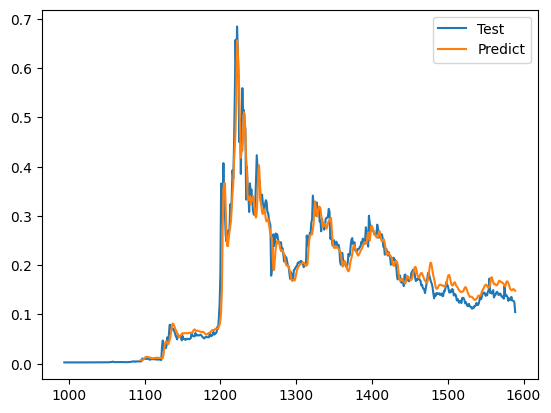

In [90]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

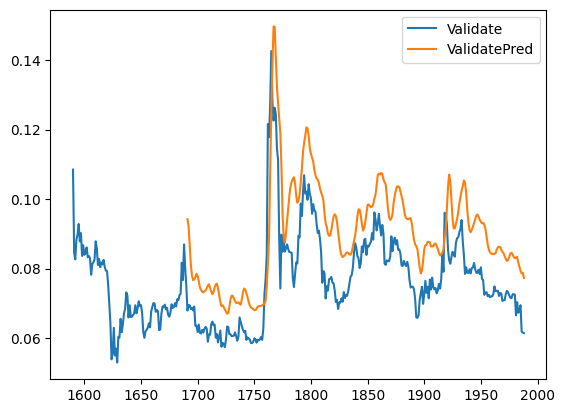

In [91]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [92]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 21.730195095162102
MAE: 0.026050160167839228
RMSE: 0.033099266542058026
--------------------------
---------TEST----------
MAPE: 169.60869336435417
MAE: 0.16386901104769996
RMSE: 0.21284841839498803
-------------------


In [93]:
val_data1.shape

(399, 1)

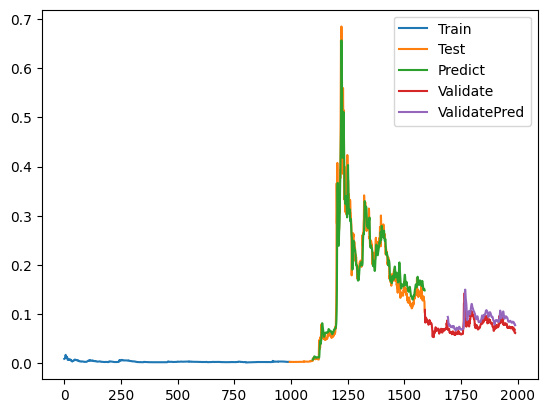

In [94]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()